In [1]:
#source EPOTFenv/bin/activate (launching and exiting the virtual environment containing the required modules, stored in the working directory for VNA_Analysis)
#EPOTFenv/bin/python your_script.py - for running a script in the virtual environment
#source deactivate

#import all the libraries needed
from imports import *
# import my functions
from functions import *

# Define the path to the output directory where data is saved
path_out =  ('/Users/horatiocox/Desktop/RUG Postdoc/Experiments/Electrical/VDP_JT029_SrRuO3')
# Define the path to the directories containing the experimental data
directory_1 = Path('/Users/horatiocox/Desktop/Electronic_properties_of_thin_films/Data/')




## Importing Measurement Data 

In [2]:
# Import the file, treating lines with non-numeric data as comments
df = pd.read_csv(directory_1.joinpath('JT029_SrRuO3_171024_Combined'), sep='\t', skiprows=6, header=None, comment='N')

# Drop unwanted columns
df.drop(df.columns[[6, 7]], axis=1, inplace=True)

# Assign headers to columns
df.columns = ['Temp', 'Field', 'Source (A)', 'Source (V)', 'Sense (V)', 'index']

# Convert columns to the appropriate data types
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')
df['Field'] = pd.to_numeric(df['Field'], errors='coerce')
df['Source (A)'] = pd.to_numeric(df['Source (A)'], errors='coerce')
df['Source (V)'] = pd.to_numeric(df['Source (V)'], errors='coerce')
df['Sense (V)'] = pd.to_numeric(df['Sense (V)'], errors='coerce')
df['index'] = pd.to_numeric(df['index'], downcast='integer', errors='coerce')

# Drop rows where all values are NaN (e.g., empty lines)
df.dropna(how='all', inplace=True)

# Convert the 'index' column to integer format
df['index'] = df['index'].astype(int)

# Check data types and column names
column_formats = [df[col].dtype for col in df.columns]
print(column_formats)

# Display the first few rows of the dataframe
print(list(df.columns))
df.head()


[dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64')]
['Temp', 'Field', 'Source (A)', 'Source (V)', 'Sense (V)', 'index']


,Temp,Field,Source (A),Source (V),Sense (V),index
0,4.9985,-0.199797,-0.00001,-0.0118,-0.000010,0
1,4.9985,-0.199797,-0.00001,-0.0118,0.000112,1
2,4.9985,-0.199797,-0.00001,-0.0118,-0.000673,2
3,4.9985,-0.199797,-0.00001,-0.0118,-0.000667,3
4,4.9985,-0.199797,-0.00001,-0.0118,-0.000541,4


In [8]:
# Split the data into separate dataframes based on the 'index' column
# This will create a dictionary of dataframes, where each dataframe corresponds to a different measurement
# The 'index' column is used to identify the measurements
df_dict = dict(tuple(df.groupby('index')))

df_first = df_dict[0]

# Display the keys of the dictionary
print("Keys of the dictionary:", df_dict.keys())
print(df_dict[0].head())

# Initialize an empty list to store the arrays
arrays = []

# Iterate over the dictionary and convert each DataFrame to a numpy array
for key in sorted(df_dict.keys()):
    df_subset = df_dict[key][['Temp', 'Field', 'Source (A)', 'Source (V)', 'Sense (V)']]
    arrays.append(df_subset.to_numpy())

# Stack the arrays along axis 2 to create a 3D numpy array where:
# axis 0 corresponds to the rows, axis 1 to the columns, and axis 2 to the measurement index 
edat2 = np.stack(arrays, axis=2)

# Display the shape of the 3D numpy array
print("\nShape of the 3D numpy array:", result_array.shape)





Keys of the dictionary: dict_keys([0, 1, 2, 3, 4, 5])
      Temp     Field  Source (A)  Source (V)     Sense (V)  index
0   4.9985 -0.199797   -0.000010    -0.01180 -9.594898e-06      0
6   4.9985 -0.199797   -0.000005    -0.00590 -7.218717e-06      0
12  4.9985 -0.199797    0.000000    -0.00001 -4.400195e-06      0
18  4.9985 -0.199797    0.000005     0.00590 -2.173516e-06      0
24  4.9985 -0.199797    0.000010     0.01183  2.286598e-07      0

Shape of the 3D numpy array: (650, 5, 6)


In [4]:
# Convert the data frame to a numpy array
ndnp = df.to_numpy()
print(ndnp.shape)

# Slice the array taking every 6th value (i.e the different index values) 
# then stack these 2d arrays to generate a 3d array
# The new array has (rows, columns, index) dimensions
edat = np.array([ndnp[q::6,:-1] for q in range(6)])
edat = edat.transpose(1,2,0)
print(edat.shape)

(3900, 6)
(650, 5, 6)


In [22]:
#####fix to put in the real fields and tempeartures averaged isntead of your input values...

# Parameters used to collect data on PPMS
start_temp = 5
end_temp = 245
step_temp = 20
max_field = 8
step_field = 2
current_points = 5 # Number of current points is used to increment the counter

#input values for temp and field into instrument
temps = list(range(start_temp, end_temp+1, step_temp))
fields = list(range(0, max_field+1, step_field)) + list(range(-max_field,0+1, step_field))


print('temps:', temps)
print('fields:', fields)



counter = 0 # Initialize a counter to zero

# Step 1: Initialize an empty np aray to store each temperature, field, and set of sheet resitivity values per row
vdp_data = np.zeros((len(temps)*len(fields), 5))

#initialize empty array to store the true temp and field values averaged for each set of currents
temp_field_store = np.zeros((len(temps)*len(fields),5,6))
# slice the data for each current point and sum them to get the average temp and field values
for i in range(current_points):
            temp_field_store += edat[i::current_points,:,:]
temp_field_store = temp_field_store/current_points
#sum over all the index values to get average temp and fields for measurements
temp_field_store = np.sum(temp_field_store, axis=2)/np.shape(edat)[2]
#tf_df = pd.DataFrame(temp_field_store[:,:,0])
#print(tf_df)


# Function to solve Van der Pauw equation
def vdp_equation(rho_sheet, R_A, R_B):
    return np.exp(-np.pi * R_A / rho_sheet) + np.exp(-np.pi * R_B / rho_sheet) - 1

for t in temps:
    for f in fields:
        # Step 2: Calculate the sheet resistivity for each temperature and field combination
        # The sheet resistivity is calculated using the Van der Pauw method
        ##########################################################
        # First pair of Van der Pauw configurations
        increment = counter*current_points
        # R_{32,10} = (V_{10}(I^+_{32}) - V_{10}(I^-_{32})) / (I^+_{32} - I^-_{32})
        R_32_10 = (edat[current_points-1+increment, 4, 2] - edat[increment, 4, 2]) / (edat[current_points-1+increment, 2, 2] - edat[increment, 2, 2])

        # R_{20,31} = (V_{31}(I^+_{20}) - V_{31}(I^-_{20})) / (I^+_{20} - I^-_{20})
        R_20_31 = (edat[current_points-1+increment, 4, 3] - edat[increment, 4, 3]) / (edat[current_points-1+increment, 2, 3] - edat[increment, 2, 3])

        R_A = (R_32_10 + R_20_31) / 2

        ##########################################################

        # Second pair of Van der Pauw configurations

        # R_{01,23} = (V_{23}(I^+_{01}) - V_{23}(I^-_{01})) / (I^+_{01} - I^-_{01})
        R_01_23 = (edat[current_points-1+increment, 4, 4] - edat[increment, 4, 4]) / (edat[current_points-1+increment, 2, 4] - edat[increment, 2, 4])

        # R_{13,02} = (V_{01}(I^+_{13}) - V_{02}(I^-_{13})) / (I^+_{13} - I^-_{13})
        R_13_02 = (edat[current_points-1+increment, 4, 5] - edat[increment, 4, 5]) / (edat[current_points-1+increment, 2, 5] - edat[increment, 2, 5])

        R_B = (R_01_23 + R_13_02) / 2

        # Solve the Van der Pauw equation for both pairs of configurations

        # Initial guess for rho_sheet
        initial_guess = 1.0

        # Solve for rho_sheet for the first pair (R_A)
        R_sheet_A = fsolve(vdp_equation, initial_guess, args=(R_32_10, R_20_31))[0]

        # Solve for rho_sheet for the second pair (R_B)
        R_sheet_B = fsolve(vdp_equation, initial_guess, args=(R_01_23, R_13_02))[0]

        # Average the two solutions for the final sheet resistivity
        R_sheet = (R_sheet_A + R_sheet_B) / 2
        
        # Step 3: Append the new row to the np array
        vdp_data[counter,:] = [temp_field_store[counter,0], temp_field_store[counter,1], R_sheet_A, R_sheet_B, R_sheet]


        #print('t=',t,'f=',f,'counter=',counter)
        counter += 1
        

print("vdp shape",vdp_data.shape)
df_vdp_data = pd.DataFrame(vdp_data, columns=['Temp', 'Field', 'R_sheet_A', 'R_sheet_B', 'R_sheet'])
print(df_vdp_data.head())



temps: [5, 25, 45, 65, 85, 105, 125, 145, 165, 185, 205, 225, 245]
fields: [0, 2, 4, 6, 8, -8, -6, -4, -2, 0]
vdp shape (130, 5)
     Temp         Field   R_sheet_A   R_sheet_B     R_sheet
0  4.9985     -0.199797  301.853711  302.079682  301.966697
1  4.9996  19999.792969  302.193331  301.967301  302.080316
2  5.0008  39999.574219  299.700518  299.700518  299.700518
3  4.9985  59999.566406  298.567421  298.680388  298.623905
4  5.0019  79999.773437  297.660944  297.547948  297.604446


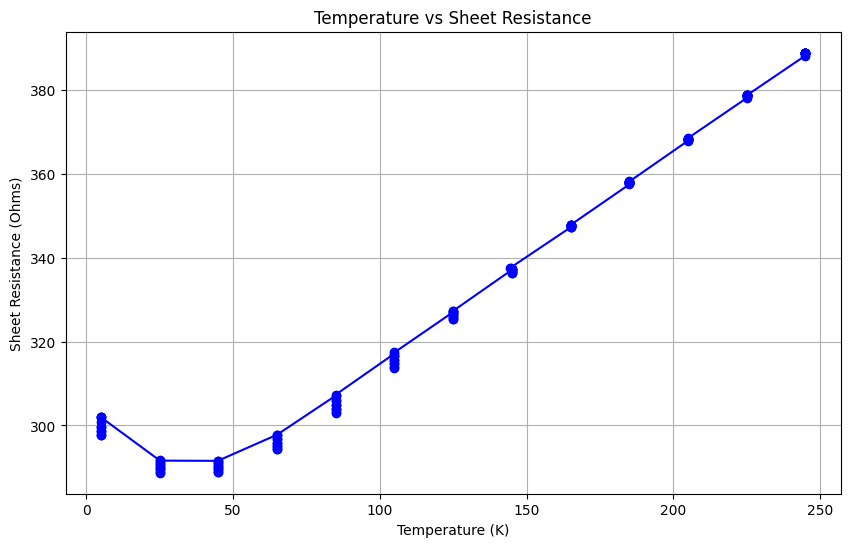

In [23]:
temp_field_store.shape
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_vdp_data['Temp'], df_vdp_data['R_sheet'], marker='o', linestyle='-', color='b')
plt.xlabel('Temperature (K)')
plt.ylabel('Sheet Resistance (Ohms)')
plt.title('Temperature vs Sheet Resistance')
plt.grid(True)
plt.show()

In [ ]:
##Use this to fit the linear region of mag and ccurrent
scipy.interpolate s

In [ ]:




total = pandas.read_csv(path_1.joinpath('a30037_0 (19) - SiO_2-.txt'),sep=' ',skiprows=10, header = None) 
data = total[3]
frames = [total[0].iloc[-1]+1, total[1].iloc[-1]+1, total[2].iloc[-1]+1] #frames stores the size of the data array e.g. resolution of image - got rid of zero indexing
print(frames)
data = data.to_numpy()

mat = np.zeros([np.size(data),6])
mat.shape

mat[:,1] = data
#total stored in zero
#oxygen stored in 1
#Silicon stored in 2
#gold stored in 3
#hydrogen stored in 4
#sio2 stored in 5


# Feeding Data into an np array and reshaping to 3D
mathi = mat.reshape((frames[2],frames[1],frames[0],6))
mathi = np.transpose(mathi,(1,2,0,3))

print(mathi.shape)
#mat = np.sum(mat,axis=0)

#saving the data
np.save(path_1.joinpath('sims2437.npy'), mathi)

In [ ]:

#R_{32,10} = (V_{10}(I^+_{32}) - V_{10}(I^-_{32})) / (I^+_{32} - I^-_{32})
R_32_10 = (edat[4::5,4,2] - edat[0::5,4,2]) / (edat[4::5,2,2] - edat[0::5,2,2])

#R_{20,31} = (V_{31}(I^+_{20}) - V_{31}(I^-_{20})) / (I^+_{20} - I^-_{20})
R_20_31 = (edat[4::5,4,3] - edat[0::5,4,3]) / (edat[4::5,2,3] - edat[0::5,2,3])

print(R_32_10.shape, R_20_31.shape)

q1 = R_32_10/R_20_31
q2 = R_20_31/R_20_31
        
- rho^A_sheet = (pi * f / ln(2)) * (R_{32,10} + R_{20,31}) / 2
- (q - 1) / (q + 1) = (f * cosh^(-1)(e^(ln(2)/f) / 2)) / ln(2)
- Where f can be taken from tables and q = max(R_{32,10}/R_{20,31}, R_{20,31}/R_{32,10})

#R_{01,23} = (V_{23}(I^+_{01}) - V_{23}(I^-_{01})) / (I^+_{01} - I^-_{01})
R_01_23 = (edat[4::5,4,4] - edat[0::5,4,4]) / (edat[4::5,2,4] - edat[0::5,2,4])

#R_{13,02} = (V_{01}(I^+_{13}) - V_{02}(I^-_{13})) / (I^+_{13} - I^-_{13})
R_20_31 = (edat[4::5,4,5] - edat[0::5,4,5]) / (edat[4::5,2,5] - edat[0::5,2,5])
    
- rho^A_sheet = (pi * f / ln(2)) * (R_{01,23} + R_{13,02}) / 2
- (q - 1) / (q + 1) = (f * cosh^(-1)(e^(ln(2)/f) / 2)) / ln(2)
- Where f can be taken from tables and q = max(R_{01,23}/R_{13,02}, R_{13,02}/R_{01,23})

#Final resistivity: given at every field and temperature
rho_vdp = (rho^A_sheet + rho^B_sheet) / 2
print(rho_vdp.shape)

#extracting Temperature, Field, Source (A) into np array with same indexing as rho
#This should therefore have the same number of rows as rho
parameters_vdp = np.divide((edat[0::5,0:2,2]+edat[1::5,0:2,2]+edat[2::5,0:2,2]+edat[3::5,0:2,2]+edat[4::5,0:2,2]),2)
print(parameters_vdp.shape[0])

if parameters_vdp.shape[0] == rho_vdp.shape:
    print('Shapes match')
else:
    print('Shapes do not match')